In [ ]:
!pip install surprise

     |████████████████████████████████| 11.8MB 264kB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.1-cp36-cp36m-linux_x86_64.whl size=1646950 sha256=ddebf3ba7925705e9abd22ae3b50f014180b6892d7bb9515e1c3b6f5000871de
  Stored in directory: /root/.cache/pip/wheels/78/9c/3d/41b419c9d2aff5b6e2b4c0fc8d25c538202834058f9ed110d0
Successfully built scikit-surprise


In [ ]:
import pandas as pd
import numpy as np
import math
import re
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from surprise import Reader, Dataset, SVD

In [ ]:
# from surprise import evaluate

In [ ]:
# Skip date
df1 = pd.read_csv('/content/drive/My Drive/N/Projects/Recommendation System/combined_data_1.txt', header = None, names = ['Cust_Id', 'Rating'], usecols = [0,1])

df1['Rating'] = df1['Rating'].astype(float)

print('Dataset 1 shape: {}'.format(df1.shape))
print('-Dataset examples-')
print(df1.iloc[::5000000, :])

Dataset 1 shape: (24058263, 2)
-Dataset examples-
          Cust_Id  Rating
0              1:     NaN
5000000   2560324     4.0
10000000  2271935     2.0
15000000  1921803     2.0
20000000  1933327     3.0


In [ ]:
#df2 = pd.read_csv('/content/drive/My Drive/N/Projects/Recommendation System/combined_data_2.txt', header = None, names = ['Cust_Id', 'Rating'], usecols = [0,1])
#df3 = pd.read_csv('/content/drive/My Drive/N/Projects/Recommendation System/combined_data_3.txt', header = None, names = ['Cust_Id', 'Rating'], usecols = [0,1])
#df4 = pd.read_csv('/content/drive/My Drive/N/Projects/Recommendation System/combined_data_4.txt', header = None, names = ['Cust_Id', 'Rating'], usecols = [0,1])


#df2['Rating'] = df2['Rating'].astype(float)
#df3['Rating'] = df3['Rating'].astype(float)
#df4['Rating'] = df4['Rating'].astype(float)

#print('Dataset 2 shape: {}'.format(df2.shape))
#print('Dataset 3 shape: {}'.format(df3.shape))
#print('Dataset 4 shape: {}'.format(df4.shape))

In [ ]:
# load less data for speed

df = df1
#df = df1.append(df2)
#df = df.append(df3)
#df = df.append(df4)

df.index = np.arange(0,len(df))
print('Full dataset shape: {}'.format(df.shape))
print('-Dataset examples-')
print(df.iloc[::5000000, :])

Full dataset shape: (24058263, 2)
-Dataset examples-
          Cust_Id  Rating
0              1:     NaN
5000000   2560324     4.0
10000000  2271935     2.0
15000000  1921803     2.0
20000000  1933327     3.0


Data Viewing

In [ ]:
p = df.groupby('Rating')['Rating'].agg(['count'])

# get movie count
movie_count = df.isnull().sum()[1]

movie_count

4499

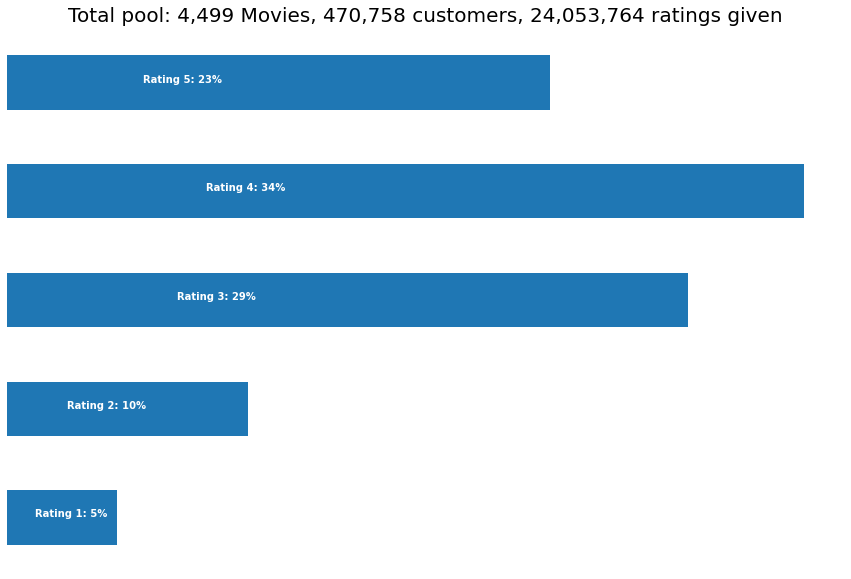

In [ ]:
# get customer count
cust_count = df['Cust_Id'].nunique() - movie_count

# get rating count
rating_count = df['Cust_Id'].count() - movie_count

ax = p.plot(kind = 'barh', legend = False, figsize = (15,10))
plt.title('Total pool: {:,} Movies, {:,} customers, {:,} ratings given'.format(movie_count, cust_count, rating_count), fontsize=20)
plt.axis('off')

for i in range(1,6):
    ax.text(p.iloc[i-1][0]/4, i-1, 'Rating {}: {:.0f}%'.format(i, p.iloc[i-1][0]*100 / p.sum()[0]), color = 'white', weight = 'bold')

Data Cleaning

In [ ]:
df_nan = pd.DataFrame(pd.isnull(df.Rating))
df_nan = df_nan[df_nan['Rating'] == True]
df_nan = df_nan.reset_index()
df_nan

,index,Rating
0,0,True
1,548,True
2,694,True
3,2707,True
4,2850,True
...,...,...
4494,24046714,True
4495,24047329,True
4496,24056849,True
4497,24057564,True


In [ ]:
movie_np = []
movie_id = 1

for i,j in zip(df_nan['index'][1:],df_nan['index'][:-1]):
  # numpy approach
  temp = np.full((1,i-j-1), movie_id)
  movie_np = np.append(movie_np, temp)
  movie_id += 1

In [ ]:
# Account for last record and corresponding length
# numpy approach
last_record = np.full((1,len(df) - df_nan.iloc[-1, 0] - 1),movie_id)
movie_np = np.append(movie_np, last_record)

print('Movie numpy: {}'.format(movie_np))
print('Length: {}'.format(len(movie_np)))

Movie numpy: [1.000e+00 1.000e+00 1.000e+00 ... 4.499e+03 4.499e+03 4.499e+03]
Length: 24053764


In [ ]:
# remove those Movie ID rows
df = df[pd.notnull(df['Rating'])]

df['Movie_Id'] = movie_np.astype(int)
df['Cust_Id'] = df['Cust_Id'].astype(int)
print('-Dataset examples-')
print(df.iloc[::5000000, :])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


-Dataset examples-
          Cust_Id  Rating  Movie_Id
1         1488844     3.0         1
5000996    501954     2.0       996
10001962   404654     5.0      1962
15002876   886608     2.0      2876
20003825  1193835     2.0      3825


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


Data Slicing

To save memory


*   Remove movie with too less reviews (they are relatively not popular)
*   Remove customer who give too less reviews (they are relatively less active)



In [ ]:
f = ['count','mean']
df_movie_summary = df.groupby('Movie_Id')['Rating'].agg(f)
df_movie_summary

,count,mean
Movie_Id,,
1,547,3.749543
2,145,3.558621
3,2012,3.641153
4,142,2.739437
5,1140,3.919298
...,...,...
4495,614,3.478827
4496,9519,3.763000
4497,714,2.715686


In [ ]:
df_movie_summary.index = df_movie_summary.index.map(int)
movie_benchmark = round(df_movie_summary['count'].quantile(0.7),0)
drop_movie_list = df_movie_summary[df_movie_summary['count'] < movie_benchmark].index
print('Movie minimum times of review: {}'.format(movie_benchmark))

Movie minimum times of review: 1799.0


In [ ]:
df_cust_summary = df.groupby('Cust_Id')['Rating'].agg(f)
df_cust_summary.index = df_cust_summary.index.map(int)
cust_benchmark = round(df_cust_summary['count'].quantile(0.7),0)
drop_cust_list = df_cust_summary[df_cust_summary['count'] < cust_benchmark].index

print('Customer minimum times of review: {}'.format(cust_benchmark))

Customer minimum times of review: 52.0


In [ ]:
print('Original Shape: {}'.format(df.shape))
df = df[~df['Movie_Id'].isin(drop_movie_list)]
df = df[~df['Cust_Id'].isin(drop_cust_list)]
print('After Trim Shape: {}'.format(df.shape))
print('-Data Examples-')
print(df.iloc[::5000000, :])

Original Shape: (24053764, 3)
After Trim Shape: (17337458, 3)
-Data Examples-
          Cust_Id  Rating  Movie_Id
696        712664     5.0         3
6932490   1299309     5.0      1384
13860273   400155     3.0      2660
20766530   466962     4.0      3923


In [ ]:
df_p = pd.pivot_table(df,values='Rating',index='Cust_Id',columns='Movie_Id')
print(df_p)

Movie_Id  3     8     16    17    18    ...  4488  4490  4492  4493  4496
Cust_Id                                 ...                              
6          NaN   NaN   NaN   NaN   NaN  ...   NaN   NaN   NaN   NaN   NaN
7          NaN   5.0   NaN   NaN   NaN  ...   NaN   NaN   NaN   NaN   NaN
79         NaN   NaN   NaN   NaN   NaN  ...   NaN   4.0   NaN   NaN   NaN
97         NaN   NaN   NaN   NaN   NaN  ...   NaN   NaN   NaN   NaN   NaN
134        NaN   NaN   NaN   NaN   NaN  ...   NaN   NaN   NaN   NaN   NaN
...        ...   ...   ...   ...   ...  ...   ...   ...   ...   ...   ...
2649370    NaN   NaN   NaN   NaN   NaN  ...   NaN   NaN   NaN   NaN   NaN
2649378    NaN   NaN   NaN   NaN   NaN  ...   NaN   NaN   NaN   NaN   NaN
2649388    NaN   NaN   NaN   NaN   NaN  ...   3.0   NaN   NaN   NaN   NaN
2649426    NaN   NaN   NaN   4.0   NaN  ...   NaN   NaN   NaN   NaN   NaN
2649429    NaN   NaN   NaN   NaN   NaN  ...   NaN   NaN   NaN   NaN   NaN

[143458 rows x 1350 columns]


Data Mapping

In [ ]:
df_title = pd.read_csv('/content/drive/My Drive/N/Projects/Recommendation System/movie_titles.csv', encoding = "ISO-8859-1", header = None, names = ['Movie_Id', 'Year', 'Name'])
df_title.set_index('Movie_Id', inplace = True)
print (df_title.head(10))

            Year                          Name
Movie_Id                                      
1         2003.0               Dinosaur Planet
2         2004.0    Isle of Man TT 2004 Review
3         1997.0                     Character
4         1994.0  Paula Abdul's Get Up & Dance
5         2004.0      The Rise and Fall of ECW
6         1997.0                          Sick
7         1992.0                         8 Man
8         2004.0    What the #$*! Do We Know!?
9         1991.0      Class of Nuke 'Em High 2
10        2001.0                       Fighter


## Recommendation Models

collaborative filtering

In [ ]:
reader = Reader()

In [ ]:
from surprise.model_selection import KFold, cross_validate

In [ ]:
# get just top 100K rows for faster run time
data = Dataset.load_from_df(df[['Cust_Id', 'Movie_Id', 'Rating']][:100000], reader)
# kf = KFold(n_splits=3)
# kf.split(data)

In [ ]:
svd=SVD()
cross_validate(svd, data, measures=['RMSE', 'MAE'], cv=3, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.9974  0.9996  0.9949  0.9973  0.0019  
MAE (testset)     0.7982  0.8036  0.7914  0.7977  0.0050  
Fit time          3.76    3.72    3.70    3.73    0.03    
Test time         0.27    0.19    0.19    0.22    0.04    


{'fit_time': (3.7617316246032715, 3.721106767654419, 3.6963837146759033),
 'test_mae': array([0.79820789, 0.80360171, 0.79142785]),
 'test_rmse': array([0.99741987, 0.99963454, 0.99488091]),
 'test_time': (0.27222657203674316, 0.18589234352111816, 0.19385552406311035)}

In [ ]:
# user 785314
df_785314 = df[(df['Cust_Id'] == 785314) & (df['Rating'] == 5)]
df_785314 = df_785314.set_index('Movie_Id')
df_785314 = df_785314.join(df_title)['Name']
print(df_785314)

Movie_Id
57                                            Richard III
175                                        Reservoir Dogs
311                                               Ed Wood
329                                                 Dogma
331                                           Chasing Amy
395                                         Captain Blood
788                                                Clerks
798                                                  Jaws
907                                       Animal Crackers
985                                             The Mummy
1552                                          Black Adder
1905    Pirates of the Caribbean: The Curse of the Bla...
2000                          Four Weddings and a Funeral
2122                                 Being John Malkovich
2342                                        Super Size Me
2360                                  Singin' in the Rain
2430                           Alien: Collector's Edition
2443 

Prediction

In [ ]:
user_785314 = df_title.copy()
user_785314 = user_785314.reset_index()
user_785314 = user_785314[~user_785314['Movie_Id'].isin(drop_movie_list)]
user_785314

,Movie_Id,Year,Name
2,3,1997.0,Character
7,8,2004.0,What the #$*! Do We Know!?
15,16,1996.0,Screamers
16,17,2005.0,7 Seconds
17,18,1994.0,Immortal Beloved
...,...,...,...
17765,17766,2002.0,Where the Wild Things Are and Other Maurice Se...
17766,17767,2004.0,Fidel Castro: American Experience
17767,17768,2000.0,Epoch
17768,17769,2003.0,The Company


In [ ]:
# getting full dataset
data = Dataset.load_from_df(df[['Cust_Id', 'Movie_Id', 'Rating']], reader)

trainset = data.build_full_trainset()
svd.fit(trainset)

In [ ]:
user_785314['Estimate_Score'] = user_785314['Movie_Id'].apply(lambda x: svd.predict(785314, x).est)

In [ ]:
user_785314 = user_785314.drop('Movie_Id', axis = 1)

user_785314 = user_785314.sort_values('Estimate_Score', ascending=False)
print(user_785314.head(10))

        Year                               Name  Estimate_Score
1799  2002.0        An Evening With Kevin Smith        5.000000
1551  1983.0                        Black Adder        5.000000
3167  1987.0          Evil Dead 2: Dead by Dawn        5.000000
4382  2004.0     Farscape: The Peacekeeper Wars        4.989085
4391  1993.0                   Army of Darkness        4.967751
3045  1990.0  The Simpsons: Treehouse of Horror        4.837910
1031  1992.0                        Hard Boiled        4.815788
2553  1975.0      The Rocky Horror Picture Show        4.736282
2018  2004.0                   Samurai Champloo        4.727786
1276  1988.0                Red Dwarf: Series 3        4.727249


Recommend with Pearsons' R correlation

get the top 10 highly correlated movies

In [ ]:
def recommend(movie_title, min_count):
  print("For movie ({})".format(movie_title))
  print("- Top 10 movies recommended based on Pearsons'R correlation - ")
  i = int(df_title.index[df_title['Name'] == movie_title][0])
  target = df_p[i]
  similar_to_target = df_p.corrwith(target)
  corr_target = pd.DataFrame(similar_to_target, columns = ['PearsonR'])
  corr_target.dropna(inplace = True)
  corr_target = corr_target.sort_values('PearsonR', ascending = False)
  corr_target.index = corr_target.index.map(int)
  corr_target = corr_target.join(df_title).join(df_movie_summary)[['PearsonR', 'Name', 'count', 'mean']]
  print(corr_target[corr_target['count']>min_count][:10].to_string(index=False))

In [ ]:
recommend("What the #$*! Do We Know!?", 0)

For movie (What the #$*! Do We Know!?)
- Top 10 movies recommended based on Pearsons'R correlation - 
 PearsonR                                      Name  count      mean
 1.000000                What the #$*! Do We Know!?  14910  3.189805
 0.505500                                 Inu-Yasha   1883  4.554434
 0.452807  Captain Pantoja and the Special Services   1801  3.417546
 0.442354                 Without a Trace: Season 1   2124  3.980226
 0.384179                      Yu-Gi-Oh!: The Movie   3173  3.331547
 0.383959                                  Scorched   2430  2.894239
 0.381173   All Creatures Great and Small: Series 1   2327  3.938118
 0.381112           As Time Goes By: Series 1 and 2   2249  4.164073
 0.373018                          Cowboys & Angels   2368  3.589527
 0.371981                            Biggie & Tupac   1866  3.019293


In [ ]:
recommend("X2: X-Men United", 0)

For movie (X2: X-Men United)
- Top 10 movies recommended based on Pearsons'R correlation - 
 PearsonR                                                   Name  count      mean
 1.000000                                       X2: X-Men United  98720  3.932202
 0.384550                               Batman Beyond: The Movie   2614  3.726855
 0.375967                                         Justice League   3591  3.710944
 0.361393                       Justice League: Justice on Trial   2961  3.718001
 0.338025                     Batman Beyond: Return of the Joker   3704  3.604752
 0.335256                                          Batman Begins  54922  4.236699
 0.328229                           Batman: Mask of the Phantasm   2823  3.767977
 0.327040  Batman: The Animated Series: Tales of the Dark Knight   2432  3.583059
 0.316666                        Dragon Ball Z: Super Android 13   2426  3.428689
 0.316166                               Mortal Kombat: The Movie   7633  3.165466
